In [1]:
import pandas as pd
import numpy as np
import os
import math
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [15]:
file_path='./data/5万水系.xlsx'
file_path1='./data/钻孔坐标.xlsx'
data=pd.read_excel(file_path,sheet_name='Sheet1')
zk=pd.read_excel(file_path1,sheet_name='Sheet2')
print(data.head())
print(zk.head())

         Y        X     As    Sb    Bi    Co    Cu    Mo    Ni    Pb     W  \
0  10465.8  76750.4  25.20  4.09  0.31  12.9  23.1  0.55  26.9  18.9  2.31   
1  10463.4  76746.2   9.42  0.90  0.32  13.8  28.2  1.18  26.9  45.5  3.96   
2  10475.2  76741.6  19.20  5.35  0.32  12.8  26.8  0.75  26.5  29.0  7.34   
3  10494.2  76753.8  26.80  4.84  0.32  14.7  26.4  0.53  29.9  21.0  2.41   
4  10490.8  76744.8   9.27  0.88  0.34  14.6  27.8  0.66  31.4  32.8  5.90   

     Zn    Au    Ag  
0  63.3  1.66  0.10  
1  65.2  1.22  0.09  
2  68.6  0.42  0.07  
3  78.1  0.88  0.07  
4  75.0  0.30  0.09  
         Y        X  label
0  11053.0  76516.0      6
1  11054.4  76516.2      6
2  11056.0  76512.5      6
3  11057.7  76512.8      6
4  11059.4  76513.0      6


In [16]:
zk_loc=zk.loc[:,['Y','X']].values
data_loc=data.loc[:,['Y','X']].values
print(zk.loc[[0,1,3],:])
print(data_loc[0])

         Y        X  label
0  11053.0  76516.0      6
1  11054.4  76516.2      6
3  11057.7  76512.8      6
[10465.8 76750.4]


In [146]:
zk_loc1=zk_loc
data_loc1=data_loc
print(np.max(zk_loc1,axis=0))
print(np.max(data_loc1,axis=0))
print(np.min(zk_loc1,axis=0))
print(np.min(data_loc1,axis=0))
data_loc1[unknown[0]]
# np.save('out/CAE_Cluster/5wan/dists',dist)

[11221.5 76685.7]
[11379.  76757.6]
[10361.4 76145.9]
[10000.2 76014. ]


array([10465.8, 76750.4])

In [18]:
R=np.array(50)#距离半径为50
true_label=[]
false_label=[]
unknown=[]
zk_label=zk['label'].values
for i in range(len(data_loc1)):
    loc=data_loc1[i]
    dist={}
    for j in range(len(zk_loc1)):
        dist[j]=np.linalg.norm(loc-zk_loc1[j])
    minv=min(dist.values())
    k=[i for i in dist if dist[i]==minv ]
    if minv>R:
        unknown.append(i)
    else:
        bl=0
        for m in k:
            if zk_label[m]==6:
                bl=1
                break
        if bl:
            true_label.append(i)
        else:
            false_label.append(i)

In [148]:
data_true=data.loc[true_label,:]
data_false=data.loc[false_label,:]
data_unknown=data.loc[unknown,:]
print(data_true.shape)
print(data_false.shape)
print(data[0:1])

(1016, 14)
(1657, 14)
         Y        X    As    Sb    Bi    Co    Cu    Mo    Ni    Pb     W  \
0  10465.8  76750.4  25.2  4.09  0.31  12.9  23.1  0.55  26.9  18.9  2.31   

     Zn    Au   Ag  
0  63.3  1.66  0.1  


In [106]:
data1=pd.DataFrame(data_true)
data2=pd.DataFrame(data_false)
data3=pd.DataFrame(data_unknown)
with pd.ExcelWriter('out/one-class-svm/5wan_r10.xlsx') as writer:
    data1.to_excel(writer,sheet_name='有矿')
    data2.to_excel(writer,sheet_name='无矿')
    data3.to_excel(writer,sheet_name='未知')    

In [20]:
# data_tv=data_true.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# data_fv=data_false.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
data_prev=data_unknown.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# data_true1=np.insert(data_tv,12,1,axis=1)
# data_false1=np.insert(data_fv,12,-1,axis=1)
traindata=data.loc[true_label+false_label,:]
train_data=traindata.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
train_label1=np.array([1]*len(true_label)+[0]*len(false_label))

In [5]:
alldata=data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# for i in range(alldata.shape[0]):
#     for j in range(alldata.shape[1]):
#         if type(alldata[i][j])==str:
#             data1.append(alldata[i][j])
#             alldata[i][j]=0
# type(alldata[0][0])
# print(data1)

In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler() #min-max标准化
alldata1=scaler.fit_transform(alldata)



In [13]:
alldata2=alldata1.reshape((alldata1.shape[0],alldata1.shape[1],1))
alldata2.shape
np.save('out/data.npy',alldata2)

In [9]:
# import tensorflow as tf 
from keras.models import Model,Input,load_model, Sequential 
from keras.layers import Conv1D, Dropout, Dense  
from keras.layers import MaxPooling1D, UpSampling1D, Flatten, Reshape 
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianDropout,GaussianNoise
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [10]:
sample_length,feature_dim=alldata2.shape[1],alldata2.shape[2]
print(sample_length,feature_dim)

12 1


In [12]:
data=Input(shape=(sample_length,feature_dim ))
x=GaussianNoise(0.01)(data)
x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length, feature_dim))(x)
x=MaxPooling1D(pool_size=2)(x)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//2,16))(x)
encoded=MaxPooling1D(pool_size=2)(x)

x=UpSampling1D(size=2)(encoded)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//2,8))(x)
x=UpSampling1D(size=2)(x)
x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length,8))(x)
decoded=Conv1D(filters= feature_dim, kernel_size=3, padding='same', activation='sigmoid',input_shape=(sample_length,16))(x)
       
autoencoder   = Model(data, decoded)
encoder_model = Model(data,encoded)
autoencoder.compile(loss="mse", optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 12, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 8)              392       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 8)              0         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 8)              0         
__________

In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#autoencoder.fit(alldata2,alldata2,epochs=100,batch_size=128,shuffle=True,validation_split=0.1,callbacks=[early_stopping])

autoencoder.fit(alldata2,alldata2,epochs=100,batch_size=128,validation_split=0.1)

Train on 10333 samples, validate on 1149 samples
Epoch 1/100


In [21]:
from sklearn.svm import OneClassSVM,SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [180]:
true_data=pd.read_excel('out/one-class-svm/5wan_r50.xlsx',sheet_name='有矿')
false_data=pd.read_excel('out/one-class-svm/5wan_r50.xlsx',sheet_name='无矿')
unknown_data=pd.read_excel('out/one-class-svm/5wan_r50.xlsx',sheet_name='未知')
print(true_data.shape)
print(false_data.shape)
print(unknown_data.shape)

(1016, 14)
(1657, 14)
(8809, 14)


In [181]:
#采用原始数据
# traindata=data.loc[true_label,:]
traindata2=true_data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# false_data=data.loc[false_label,:]
false_data2=false_data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# unknown_data1=data.loc[unknown,:]
unknown_data2=unknown_data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler() #min-max标准化
scaler=preprocessing.StandardScaler()
train_data2=scaler.fit_transform(traindata2)
false_data2=scaler.fit_transform(false_data2)
unknown_data2=scaler.fit_transform(unknown_data2)

In [197]:
#采用压缩数据
true_label=true_label
false_label=false_label
unknown=unknown
alldata=np.load('out/one-class-svm/encoded_data1.npy')

unknown_data1=np.array([alldata[i] for i in unknown])
train_data1=np.array([alldata[i] for i in true_label])
false_data1=np.array([alldata[i] for i in false_label])

t_label=[1]*len(true_label)
f_label=[-1]*len(false_label)

In [190]:
train_data=train_data1
x_train,x_test,y_train,y_test=train_test_split(train_data,t_label,test_size=0.1,random_state=1,stratify=t_label)
# x_train,x_test,y_train,y_test=train_test_split(train_data,train_label1,train_size=1000,random_state=1)
x_train.shape

(914, 3)

In [191]:
#交叉训练验证
# kernel=['linear','rbf','sigmoid']
kernel=['rbf']
gammaList=np.logspace(-10,2,100)
para=[]
max_acc=0
all_para=[]
for gam in gammaList:
    ocsvm= OneClassSVM(nu=0.01, kernel='rbf', gamma=gam).fit(x_train)
    y_pred = ocsvm.predict(x_test) #测试集预测
    acc_score = metrics.accuracy_score(y_test,y_pred)   #测试准确率
    all_para.append([k,gam,round(acc_score,4)])
    if acc_score > max_acc:
        para=[k,gam]
        max_acc=acc_score
    print('kernel:',k,'gamma:',gam,'Acc_score:',round(acc_score,4))

kernel: rbf gamma: 1e-10 Acc_score: 0.0
kernel: rbf gamma: 1.3219411484660286e-10 Acc_score: 0.0
kernel: rbf gamma: 1.747528400007683e-10 Acc_score: 0.0
kernel: rbf gamma: 2.310129700083158e-10 Acc_score: 0.0
kernel: rbf gamma: 3.0538555088334126e-10 Acc_score: 0.0
kernel: rbf gamma: 4.03701725859655e-10 Acc_score: 0.0
kernel: rbf gamma: 5.336699231206302e-10 Acc_score: 0.0
kernel: rbf gamma: 7.054802310718631e-10 Acc_score: 0.0
kernel: rbf gamma: 9.32603346883218e-10 Acc_score: 0.0
kernel: rbf gamma: 1.2328467394420635e-09 Acc_score: 0.0
kernel: rbf gamma: 1.6297508346206469e-09 Acc_score: 0.0
kernel: rbf gamma: 2.1544346900318866e-09 Acc_score: 0.0
kernel: rbf gamma: 2.848035868435805e-09 Acc_score: 0.0
kernel: rbf gamma: 3.764935806792472e-09 Acc_score: 0.0
kernel: rbf gamma: 4.977023564332114e-09 Acc_score: 0.0
kernel: rbf gamma: 6.579332246575682e-09 Acc_score: 0.0
kernel: rbf gamma: 8.697490026177834e-09 Acc_score: 0.0
kernel: rbf gamma: 1.1497569953977357e-08 Acc_score: 0.0
kern

In [203]:
#测试集验证
print(para,max_acc)
k,gam=para[0:2]
ocsvm = OneClassSVM(nu=0.01,kernel=k,gamma=gam).fit(x_train)
y_pred = ocsvm.predict(x_test)
class_report=metrics.classification_report(y_test,y_pred)
acc=metrics.accuracy_score(y_test,y_pred)
print(metrics.classification_report(y_test,y_pred))
print('acc:',metrics.accuracy_score(y_test,y_pred))


['rbf', 0.0003511191734215135] 0.9803921568627451
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.98      0.99       102

   micro avg       0.98      0.98      0.98       102
   macro avg       0.50      0.49      0.50       102
weighted avg       1.00      0.98      0.99       102

acc: 0.9803921568627451


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [205]:
#对负样本测试
# k,gam=para[0:2]
# ocsvm = OneClassSVM(nu=0.01,kernel=k,gamma=gam).fit(x_train)
f_pred = ocsvm.predict(false_data1)
class_report=metrics.classification_report(f_label,f_pred)
acc=metrics.accuracy_score(f_label,f_pred)
print(metrics.classification_report(f_label,f_pred))
print('acc:',metrics.accuracy_score(f_label,f_pred))
print(f_pred)

              precision    recall  f1-score   support

          -1       1.00      0.03      0.05      1657
           1       0.00      0.00      0.00         0

   micro avg       0.03      0.03      0.03      1657
   macro avg       0.50      0.01      0.03      1657
weighted avg       1.00      0.03      0.05      1657

acc: 0.02715751357875679
0.02715751357875679
[1 1 1 ... 1 1 1]


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


8809
Yes! it is


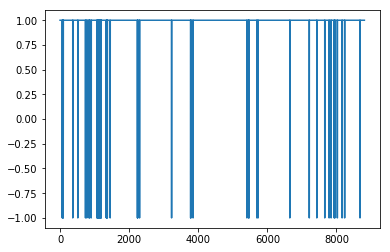

In [175]:
#对未知样本预测
k,gam=para[0:2]
ocsvm = OneClassSVM(nu=0.01,kernel=k,gamma=gam).fit(x_train)
y_pred = ocsvm.predict(unknown_data)
print(len(y_pred))
if 1 in y_pred:
    print('Yes! it is')
else:
    print('No,cannot find target')
pre_true=[]
pre_false=[]
for i in range(len(y_pred)):
    if y_pred[i]==1:
        pre_true.append(unknown[i])
    else:
        pre_false.append(unknown[i])
pretrue_data=data.loc[pre_true,:]
prefalse_data=data.loc[pre_false,:]
data4=pd.DataFrame(pretrue_data)
data5=pd.DataFrame(prefalse_data)
with pd.ExcelWriter('out/one-class-svm/encoded.xlsx') as writer:
    data4.to_excel(writer,sheet_name='预测有矿')
    data5.to_excel(writer,sheet_name='预测无矿')
import matplotlib.pyplot as plt
plt.plot(y_pred)

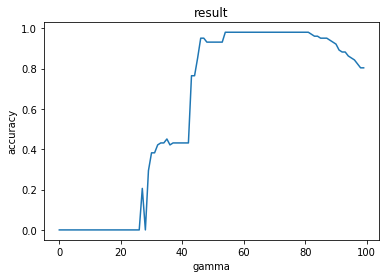

<Figure size 432x288 with 0 Axes>

In [176]:
import matplotlib.pyplot as plt
x=[all_para[i][1] for i in range(len(all_para) )]
y=[all_para[i][2] for i in range(len(all_para) )]
plt.plot(y)
plt.title('result')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.show()
plt.savefig('out/one-class svm/unencoded_gamma.fig')